In [1]:
import abc
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
import datetime
import pandas as pd
import pickle
import datetime
import random
import tensorflow_addons as tfa

In [2]:
CLASS_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 
               'horse', 'ship', 'truck']

In [3]:
class CNNModel(tf.keras.Model):
    def __init__(self, kernel_size, pool_size, pooling=tf.keras.layers.MaxPool2D):
        """Inits the class."""
        super(CNNModel, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=64, kernel_size=kernel_size, 
                                            strides=(1,1), use_bias=True,
                                            input_shape=(32, 32, 3)
                                            )
        self.pool1 = pooling(pool_size=pool_size, strides=(2,2))
        
        self.conv2 = tf.keras.layers.Conv2D(filters=64, kernel_size=kernel_size, 
                                            strides=(1,1), use_bias=True)
        self.pool2 = pooling(pool_size=pool_size, strides=(2,2))
        
        self.flatten = tf.keras.layers.Flatten()
        
        self.fc1 = tf.keras.layers.Dense(units=384)
        self.fc2 = tf.keras.layers.Dense(units=192)
        self.fc3 = tf.keras.layers.Dense(units=10)

    def call(self, inputs, training=False):
        """Makes forward pass of the network."""
        x = self.conv1(inputs)
        x = tf.keras.activations.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = tf.keras.activations.relu(x)
        x = self.pool2(x)
        
        x = self.flatten(x)
        
        x = self.fc1(x)
        x = tf.keras.activations.relu(x)
        
        x = self.fc2(x)
        x = tf.keras.activations.relu(x)
        
        x = self.fc3(x)
        x = tf.keras.activations.softmax(x)
        
        return x

    def fit(self, **kwargs):
        """Implements learning loop for the model.
        
        kwargs can contain optional parameters such as 
        num_epochs, batch_size, etc.
        """
        self.epoch_loss = []
        self.epoch_accuracy = []
        self.epoch_fscore = []
        self.epoch_time = []
        
        x_train, y_train, epochs, batch_size, cost_func, learning_coef, optimizer = self._get_params(**kwargs)
        
        weight_decay = kwargs.get('weight_decay', None)
        if weight_decay is not None:
            optimizer = optimizer(weight_decay=weight_decay, learning_rate=learning_coef)
        else:
            optimizer = optimizer(learning_rate=learning_coef)
        train_dataset = self._extract_train_dataset(x_train, y_train, batch_size)

        for epoch in range(epochs):
            start = datetime.datetime.now()
            epoch_acc = tf.keras.metrics.SparseCategoricalAccuracy()

            for x, y in train_dataset:
                x = tf.dtypes.cast(x, tf.float32)
                y = tf.dtypes.cast(y, tf.float32)

                with tf.GradientTape() as tape:
                    logits = self.call(x, training=True)
                    loss_value = cost_func(y, logits)

                grads = tape.gradient(loss_value, self.trainable_variables)
                optimizer.apply_gradients(zip(grads, self.trainable_variables))

                epoch_acc.update_state(y, logits)
                self.epoch_loss.append(loss_value)
                
            end = datetime.datetime.now()
            diff = end - start
            self.epoch_time.append(diff.total_seconds())
            
            self.epoch_accuracy.append(epoch_acc.result().numpy())

            print("Epoch {:02d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                        self.epoch_loss[-1], 
                                                                        self.epoch_accuracy[-1]))

    def predict(self, x):
        """Predicts outputs based on inputs (x)."""
        x_dataset = self._extract_test_dataset(x, batch_size=1000)
        prediction = []
        for x in x_dataset:
            logits = self.call(x)
            prediction.extend(tf.argmax(logits, axis=1, output_type=tf.int32))
        return prediction
    
    def _extract_train_dataset(self, x_train, y_train, batch_size):
        x_train = self._preprocess_x(x_train)
      
        train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
        train_dataset = train_dataset.shuffle(buffer_size=50000).batch(batch_size=batch_size)
        return train_dataset
    
    def _extract_test_dataset(self, x_train, batch_size):
        x_train = self._preprocess_x(x_train)
      
        train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
        train_dataset = train_dataset.batch(batch_size=batch_size)
        return train_dataset
    
    def _preprocess_x(self, x_set):
        x_set = x_set / 255.0
        return x_set
    
    def _get_params(self, **kwargs):
        x_train = kwargs.get('x', None)
        y_train = kwargs.get('y', None)
        epochs = kwargs.get('epochs', 10)
        batch_size = kwargs.get('batch_size', 100)
        cost_func = kwargs.get('cost_func', tf.keras.losses.SparseCategoricalCrossentropy())
        learning_coef = kwargs.get('learning_coef', 0.001)
        optimizer = kwargs.get('optimizer', tf.keras.optimizers.Adam)
        return x_train, y_train, epochs, batch_size, cost_func, learning_coef, optimizer


In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [5]:
def plot_confusion_matrix(x_test, y_pred):
    conf_matrix = tf.math.confusion_matrix(y_pred, y_test).numpy()
    conf_matrix = np.around(conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis], decimals=2)

    fig, ax = plt.subplots(figsize=(10,10))   
    ax = sns.heatmap(conf_matrix, cmap="PiYG", annot=True, center=0)
    ax.yaxis.set_ticklabels(CLASS_NAMES, rotation=0, ha='right', fontsize=14)
    ax.xaxis.set_ticklabels(CLASS_NAMES, rotation=45, ha='right', fontsize=14)
    

# y_pred = model.predict(x_test)
# plot_confusion_matrix(x_test, y_pred)

In [6]:
def get_wrongly_classified_images(x_test, y_pred, y_test):
    images = []
    labels_pred = []
    labels_real = []
    classes = {}
    for i in range(10):
        classes[i] = 0

    for image, pred, real in zip(x_test, y_pred, y_test):
        if pred != real and classes[real.item()] < 3:
            images.append(image)
            labels_pred.append(pred)
            labels_real.append(real.item())
            classes[real.item()] += 1
    return images, labels_pred, labels_real

def show_images(images, labels_pred, labels_real):
    labels_real, labels_pred, images = zip(*sorted(zip(labels_real, labels_pred, images), key=lambda tup: tup[0]))
    fig = plt.figure(figsize=(7,9))
    fig.subplots_adjust(wspace=1.4, hspace=1)
    for n in range(30):
        ax = plt.subplot(10, 3, n+1)
        plt.imshow(images[n])
        title = str(CLASS_NAMES[labels_real[n]]) + '/' + str(CLASS_NAMES[labels_pred[n]])
        plt.title(title, fontsize = 10)
        plt.axis('off')
        
# images, labels_pred, labels_real = get_wrongly_classified_images(x_test, y_pred, y_test)
# show_images(images, labels_pred, labels_real)

In [7]:
def visualize(model, x_test, y_test):
    fig, ax = plt.subplots()
    plt.plot(model.epoch_loss)
    ax.set_title('Epoch loss')
    plt.show()
    plt.clf()
    
    fig, ax = plt.subplots()
    plt.plot(model.epoch_accuracy)
    ax.set_title('Epoch accuracy')
    plt.show()
    plt.clf()
    
    fig, ax = plt.subplots()
    plt.plot(model.epoch_time)
    ax.set_title('Epoch time')
    plt.show()
    plt.clf()
    
    y_pred = model.predict(x_test)
    plot_confusion_matrix(x_test, y_pred)
    images, labels_pred, labels_real = get_wrongly_classified_images(x_test, y_pred, y_test)
    show_images(images, labels_pred, labels_real)

In [8]:
batch_size = 100
learning_coef = 0.01  # 0.01
epochs = 10
cost_func = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD


def test_params_base(batch_size, learning_coef, epochs, cost_func, optimizer,
                     kernel_size, pool_size, pooling, weight_decay=None,
                     x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test):
    model = CNNModel(kernel_size=kernel_size, pool_size=pool_size, pooling=pooling)
    
    print("Started fitting")

    model.fit(x=x_train, y=y_train, batch_size=batch_size, learning_coef=learning_coef, 
             epochs=epochs, cost_func=cost_func, optimizer=optimizer, weight_decay=weight_decay)
    
    y_pred = model.predict(x_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    loss = model.epoch_loss[-1]
    return model, acc, f1, loss.numpy()

In [9]:
# %%time

# batch_size = 100
# learning_coef = 0.001
# epochs = 1
# cost_func = tf.keras.losses.SparseCategoricalCrossentropy()
# optimizer = tf.keras.optimizers.Adam
# kernel_size = (3, 3)
# pool_size = (4, 4)
# pooling = tf.keras.layers.MaxPool2D


# results = test_params_base(batch_size=batch_size, learning_coef=learning_coef, 
#                            epochs=epochs, cost_func=cost_func, 
#                            optimizer=optimizer, kernel_size=kernel_size, 
#                            pool_size=pool_size, pooling=pooling)
# model, acc, f1, loss = results
    
# res_df = pd.DataFrame(columns=['batch_size', 'learning_coef', 'epochs', 
#                                'cost_func', 'optimizer', 'kernel_size', 
#                                'pool_size', 'pooling', 'acc', 'f1', 'loss', 'time'])
# res_df = res_df.append({'batch_size': batch_size, 'learning_coef': learning_coef,
#                         'epochs': epochs, 'cost_func': type(cost_func).__name__, 
#                         'optimizer': optimizer.__name__, 
#                         'kernel_size': kernel_size, 'pool_size': pool_size, 
#                         'pooling': pooling.__name__, 
#                         'acc': acc, 'f1': f1, 'loss': loss, 
#                         'time': sum(model.epoch_time)}, 
#                        ignore_index=True)

# print('Time: {}'.format(sum(model.epoch_time)))

# with open('results.csv', 'a') as f:
#     res_df.to_csv(f, header=False)
    
# now = datetime.datetime.now()
# now = str(now).replace(':', '_').replace(' ', '_').replace('.', '_').replace('-', '_')
# tf.saved_model.save(model, "model_{}_{}".format(now, acc))

# Data Augmentation

1. only ```x_augmented = tf.image.flip_left_right(x)```

2. augmentations 0-6

3. all color changes in one augmentation

In [10]:
def test_params_augmentation(batch_size, learning_coef, epochs, cost_func, optimizer,
                     kernel_size, pool_size, pooling,
                     x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test):
    model = CNNModelAugmentation(kernel_size=kernel_size, pool_size=pool_size, pooling=pooling)
    
    print("Started fitting")

    model.fit(x=x_train, y=y_train, batch_size=batch_size, learning_coef=learning_coef, 
             epochs=epochs, cost_func=cost_func, optimizer=optimizer)
    
    y_pred = model.predict(x_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    loss = model.epoch_loss[-1]
    return model, acc, f1, loss.numpy()

In [11]:
class CNNModelAugmentation(CNNModel):
    def __init__(self, kernel_size, pool_size, pooling=tf.keras.layers.MaxPool2D):
        """Inits the class."""
        super().__init__(kernel_size, pool_size, pooling)

    def fit(self, **kwargs):
        """Implements learning loop for the model.
        
        kwargs can contain optional parameters such as 
        num_epochs, batch_size, etc.
        """
        self.epoch_loss = []
        self.epoch_accuracy = []
        self.epoch_fscore = []
        self.epoch_time = []
        
        x_train, y_train, epochs, batch_size, cost_func, learning_coef, optimizer = self._get_params(**kwargs)
        
        optimizer = optimizer(learning_rate=learning_coef)
        train_dataset = self._extract_train_dataset(x_train, y_train, batch_size)

        for epoch in range(epochs):
            start = datetime.datetime.now()
            epoch_acc = tf.keras.metrics.SparseCategoricalAccuracy()

            for x, y in train_dataset:
                if random.random() > 0.6:
                    x = self.augmentation(x)
                
                x = tf.dtypes.cast(x, tf.float32)
                y = tf.dtypes.cast(y, tf.float32)

                with tf.GradientTape() as tape:
                    logits = self.call(x)
                    loss_value = cost_func(y, logits)

                grads = tape.gradient(loss_value, self.trainable_variables)
                optimizer.apply_gradients(zip(grads, self.trainable_variables))

                epoch_acc.update_state(y, logits)
                self.epoch_loss.append(loss_value)
                
            end = datetime.datetime.now()
            diff = end - start
            self.epoch_time.append(diff.total_seconds())
            
            self.epoch_accuracy.append(epoch_acc.result().numpy())

            print("Epoch {:02d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                        self.epoch_loss[-1], 
                                                                        self.epoch_accuracy[-1]))
    def augmentation(self, x):
        augm_type = random.choice([0])  # , 1, 2, 3])
        if augm_type == 0:
            x = tf.image.flip_left_right(x)
        elif augm_type == 1:
            x = tf.image.rot90(x, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
        elif augm_type == 2:
            x = tf.image.random_flip_left_right(x)
            x = tf.image.random_flip_up_down(x)
        elif augm_type == 3:
            x = tf.image.random_hue(x, 0.08)
            x = tf.image.random_saturation(x, 0.6, 1.6)
            x = tf.image.random_brightness(x, 0.05)
            x = tf.image.random_contrast(x, 0.7, 1.3)
        return x

In [12]:
# %%time

# name = 'Augm'

# batch_size = 100
# learning_coef = 0.001
# epochs = 10
# cost_func = tf.keras.losses.SparseCategoricalCrossentropy()
# optimizer = tf.keras.optimizers.Adam
# kernel_size = (3, 3)
# pool_size = (4, 4)
# pooling = tf.keras.layers.MaxPool2D


# results = test_params_augmentation(batch_size=batch_size, learning_coef=learning_coef, 
#                            epochs=epochs, cost_func=cost_func, 
#                            optimizer=optimizer, kernel_size=kernel_size, 
#                            pool_size=pool_size, pooling=pooling)
# model, acc, f1, loss = results
    
# res_df = pd.DataFrame(columns=['name', 'batch_size', 'learning_coef', 'epochs', 
#                                'cost_func', 'optimizer', 'kernel_size', 
#                                'pool_size', 'pooling', 'acc', 'f1', 'loss', 'time'])
# res_df = res_df.append({'name':name, 'batch_size': batch_size, 'learning_coef': learning_coef,
#                         'epochs': epochs, 'cost_func': type(cost_func).__name__, 
#                         'optimizer': optimizer.__name__, 
#                         'kernel_size': kernel_size, 'pool_size': pool_size, 
#                         'pooling': pooling.__name__, 
#                         'acc': acc, 'f1': f1, 'loss': loss, 
#                         'time': sum(model.epoch_time)}, 
#                        ignore_index=True)

# print('Time: {}'.format(sum(model.epoch_time)))

# with open('results.csv', 'a') as f:
#     res_df.to_csv(f, header=False)
    
# now = datetime.datetime.now()
# now = str(now).replace(':', '_').replace(' ', '_').replace('.', '_').replace('-', '_')
# tf.saved_model.save(model, "augm_{}_{}".format(now, acc))

# Regularization - weight decay

1. weight_decay = 0.3  - acc=~0.1

2. weight_decay = 0.01 - acc=~0.23

3. weight_decay = 0.001 -> wpisany do results.csv

In [13]:
# %%time

# name = 'Weight_decay'

# batch_size = 100
# learning_coef = 0.001
# epochs = 10
# cost_func = tf.keras.losses.SparseCategoricalCrossentropy()
# optimizer = tfa.optimizers.AdamW
# weight_decay = 0.001
# kernel_size = (3, 3)
# pool_size = (4, 4)
# pooling = tf.keras.layers.MaxPool2D


# results = test_params_base(batch_size=batch_size, learning_coef=learning_coef, 
#                            epochs=epochs, cost_func=cost_func, 
#                            optimizer=optimizer, kernel_size=kernel_size, 
#                            pool_size=pool_size, pooling=pooling, weight_decay=weight_decay)
# model, acc, f1, loss = results
    
# res_df = pd.DataFrame(columns=['name', 'batch_size', 'learning_coef', 'epochs', 
#                                'cost_func', 'optimizer', 'kernel_size', 
#                                'pool_size', 'pooling', 'acc', 'f1', 'loss', 'time'])
# res_df = res_df.append({'name':name, 'batch_size': batch_size, 'learning_coef': learning_coef,
#                         'epochs': epochs, 'cost_func': type(cost_func).__name__, 
#                         'optimizer': optimizer.__name__, 
#                         'kernel_size': kernel_size, 'pool_size': pool_size, 
#                         'pooling': pooling.__name__, 
#                         'acc': acc, 'f1': f1, 'loss': loss, 
#                         'time': sum(model.epoch_time)}, 
#                        ignore_index=True)

# print('Time: {}'.format(sum(model.epoch_time)))

# with open('results.csv', 'a') as f:
#     res_df.to_csv(f, header=False)
    
# now = datetime.datetime.now()
# now = str(now).replace(':', '_').replace(' ', '_').replace('.', '_').replace('-', '_')
# tf.saved_model.save(model, "wd_{}_{}".format(now, acc))

# Regularization - dropout

1. rate = 0.5

2. rate = 0.1

In [14]:
def test_params_dropout(batch_size, learning_coef, epochs, cost_func, optimizer,
                     kernel_size, pool_size, pooling,
                     x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test):
    model = CNNModelDropout(kernel_size=kernel_size, pool_size=pool_size, pooling=pooling)
    
    print("Started fitting")

    model.fit(x=x_train, y=y_train, batch_size=batch_size, learning_coef=learning_coef, 
             epochs=epochs, cost_func=cost_func, optimizer=optimizer)
    
    y_pred = model.predict(x_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    loss = model.epoch_loss[-1]
    return model, acc, f1, loss.numpy()

In [15]:
class CNNModelDropout(CNNModel):
    def __init__(self, kernel_size, pool_size, pooling=tf.keras.layers.MaxPool2D):
        """Inits the class."""
        super(CNNModelDropout, self).__init__(kernel_size, pool_size, pooling)

    def call(self, inputs, training=False):
        """Makes forward pass of the network."""
        x = inputs
        if training:
            x = tf.nn.dropout(x, rate=0.1)
        x = self.conv1(x)
        x = tf.keras.activations.relu(x)
        x = self.pool1(x)
        
        if training:
            x = tf.nn.dropout(x, rate=0.1)
        x = self.conv2(x)
        x = tf.keras.activations.relu(x)
        x = self.pool2(x)
        
        if training:
            x = tf.nn.dropout(x, rate=0.1)
        x = self.flatten(x)
        x = self.fc1(x)
        x = tf.keras.activations.relu(x)
        
        if training:
            x = tf.nn.dropout(x, rate=0.1)
        x = self.fc2(x)
        x = tf.keras.activations.relu(x)
        
        if training:
            x = tf.nn.dropout(x, rate=0.1)
        x = self.fc3(x)
        x = tf.keras.activations.softmax(x)
        
        return x

In [16]:
# %%time

# name = 'Dropout'

# batch_size = 100
# learning_coef = 0.001
# epochs = 10
# cost_func = tf.keras.losses.SparseCategoricalCrossentropy()
# optimizer = tf.keras.optimizers.Adam
# kernel_size = (3, 3)
# pool_size = (4, 4)
# pooling = tf.keras.layers.MaxPool2D


# results = test_params_dropout(batch_size=batch_size, learning_coef=learning_coef, 
#                            epochs=epochs, cost_func=cost_func, 
#                            optimizer=optimizer, kernel_size=kernel_size, 
#                            pool_size=pool_size, pooling=pooling)
# model, acc, f1, loss = results
    
# res_df = pd.DataFrame(columns=['name', 'batch_size', 'learning_coef', 'epochs', 
#                                'cost_func', 'optimizer', 'kernel_size', 
#                                'pool_size', 'pooling', 'acc', 'f1', 'loss', 'time'])
# res_df = res_df.append({'name':name, 'batch_size': batch_size, 'learning_coef': learning_coef,
#                         'epochs': epochs, 'cost_func': type(cost_func).__name__, 
#                         'optimizer': optimizer.__name__, 
#                         'kernel_size': kernel_size, 'pool_size': pool_size, 
#                         'pooling': pooling.__name__, 
#                         'acc': acc, 'f1': f1, 'loss': loss, 
#                         'time': sum(model.epoch_time)}, 
#                        ignore_index=True)

# print('Time: {}'.format(sum(model.epoch_time)))

# with open('results.csv', 'a') as f:
#     res_df.to_csv(f, header=False)
    
# now = datetime.datetime.now()
# now = str(now).replace(':', '_').replace(' ', '_').replace('.', '_').replace('-', '_')
# tf.saved_model.save(model, "dropout_{}_{}".format(now, acc))

# Results

In [18]:
results = pd.read_csv('results.csv')

In [19]:
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

def highlight_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_min = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_min]

In [20]:
results[['name', 'acc', 'f1', 'loss', 'time']].style.apply(highlight_max, subset=['acc', 'f1']).apply(highlight_min, subset=['loss', 'time'])

,name,acc,f1,loss,time
0,None,0.7556,0.7556,0.400648,690.875
1,Augm1,0.7638,0.7638,0.614557,581.093
2,Augm2,0.735,0.735,0.581137,539.268
3,Augm3,0.7249,0.7249,0.505278,576.916
4,Weight_decay_0.001,0.6098,0.6098,1.09986,624.368
5,Dropout_0.5,0.6666,0.6666,0.933662,595.989
6,Dropout_0.1,0.6403,0.6403,0.935953,639.021


In [21]:
%%time

name = 'Augm1.2'

batch_size = 100
learning_coef = 0.001
epochs = 10
cost_func = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam
kernel_size = (3, 3)
pool_size = (4, 4)
pooling = tf.keras.layers.MaxPool2D


results = test_params_augmentation(batch_size=batch_size, learning_coef=learning_coef, 
                           epochs=epochs, cost_func=cost_func, 
                           optimizer=optimizer, kernel_size=kernel_size, 
                           pool_size=pool_size, pooling=pooling)
model, acc, f1, loss = results

Started fitting
Epoch 00: Loss: 1.225, Accuracy: 45.634%
Epoch 01: Loss: 1.117, Accuracy: 61.212%
Epoch 02: Loss: 0.850, Accuracy: 67.096%
Epoch 03: Loss: 0.762, Accuracy: 70.568%
Epoch 04: Loss: 0.601, Accuracy: 72.836%
Epoch 05: Loss: 0.872, Accuracy: 74.920%
Epoch 06: Loss: 0.587, Accuracy: 76.574%
Epoch 07: Loss: 0.869, Accuracy: 77.634%
Epoch 08: Loss: 0.861, Accuracy: 78.986%
Epoch 09: Loss: 0.503, Accuracy: 80.050%

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Time: 633.578861
CPU times: user 4min 55s, sys: 19.9 s, total: 5min 15s
Wall time:

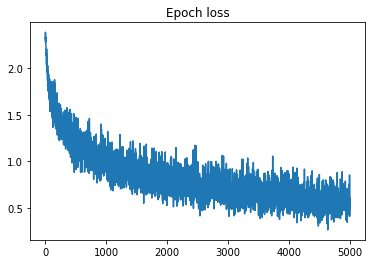

<Figure size 432x288 with 0 Axes>

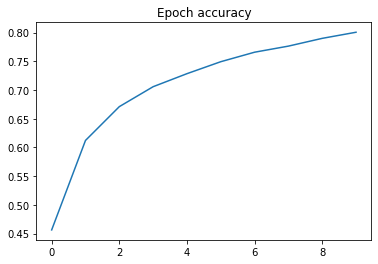

<Figure size 432x288 with 0 Axes>

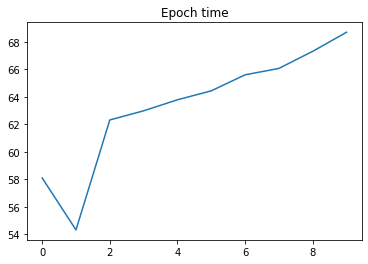

<Figure size 432x288 with 0 Axes>

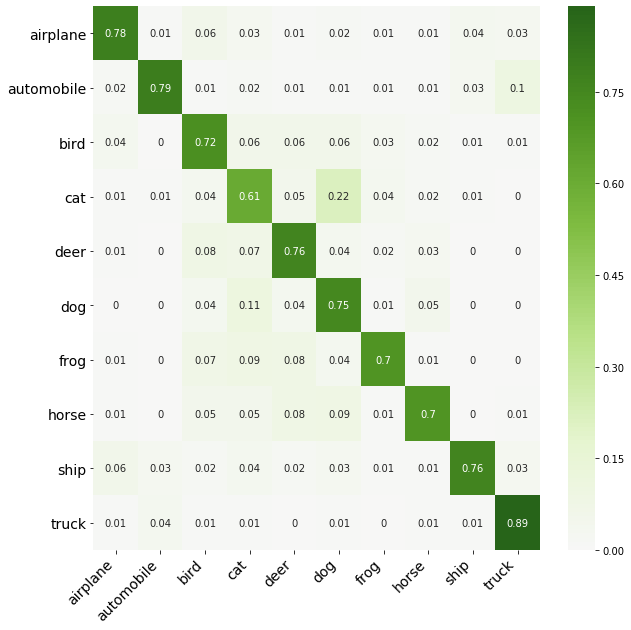

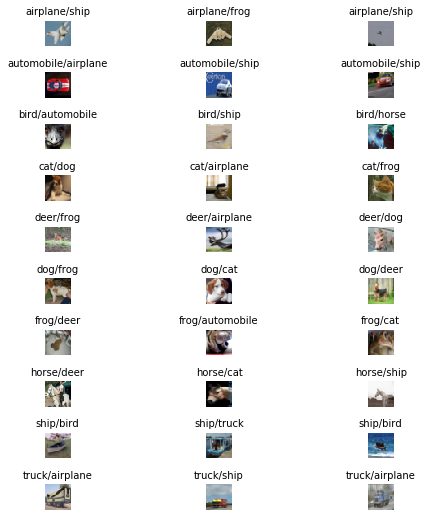

In [22]:
visualize(model, x_test, y_test)

# Wnioski
- Najlepsze wyniki były z Data Augmentation, ale tylko z odbiciem w poziomie obrazków (pozostałe metody pogarszały wyniki);
- Weight decay też pogorszył wyniki;
- Dropout też spowodował, że wyniki były gorsze;
- Być może było to spowodowane tym, że było za mało epok - przy większej liczbie epok data augmentation oraz dropout mogłyby dać lepsze wyniki;
- Najlepsze osiągnięte accuracy to 0.7638.